In [168]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd

def significant_test_violin(dist_pred_target, dist_pred_original):
    # 转 numpy
    if isinstance(dist_pred_target, torch.Tensor):
        dist_pred_target = dist_pred_target.cpu().numpy()
    if isinstance(dist_pred_original, torch.Tensor):
        dist_pred_original = dist_pred_original.cpu().numpy()

    # 多维 → L2 距离
    if dist_pred_target.ndim > 1:
        dist_pred_target = np.linalg.norm(dist_pred_target, axis=1)
    if dist_pred_original.ndim > 1:
        dist_pred_original = np.linalg.norm(dist_pred_original, axis=1)

    # 整理 dataframe
    df = pd.DataFrame({
        "Distance": np.concatenate([dist_pred_target, dist_pred_original]),
        "Type": ["Pred→Target"]*len(dist_pred_target) + ["Pred→Original"]*len(dist_pred_original)
    })

    # 画图
    plt.figure(figsize=(8,6))
    sns.violinplot(
        data=df, x="Type", y="Distance",
        palette=["#6A5ACD", "#FF6F61"],
        cut=0, inner=None
    )
    sns.boxplot(
        data=df, x="Type", y="Distance",
        width=0.18, showcaps=True, showfliers=False,
        boxprops={"facecolor":"white"},
        medianprops={"color":"black"}
    )

    plt.title("Activation Distance Comparison (Violin Plot)", fontsize=15)
    plt.xlabel("")
    plt.ylabel("Activation Distance", fontsize=13)
    plt.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

### Distribution Visualization

In [158]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys

sys.path.append("../")
from vti_utils.visualization import pca_project_2d

def visualize_distributions_RQ3(
    test_other_original, test_biology_original, pred_other, pred_biology,
    title="Idefics3-8B-Llama3 on ScienceQA (Biology)",
    save_path=None
):
    '''
    Input: test_other_original, test_biology_original, pred_other, pred_biology
    '''
    ds = [
        test_other_original, test_biology_original, pred_other, pred_biology
    ]
    proj_list, V2, mean = pca_project_2d(ds)

    # === 使用 seaborn 绘图 ===
    # 设置 seaborn 样式
    sns.set_style("whitegrid")
    sns.set_palette("husl")
    sns.set_theme(style="ticks")
    
    # 准备数据用于 seaborn
    data_list = []
    sizes = [60, 90, 60, 25]  
    labels = ["Original Out", "Original In", "Pred Out", "Pred In"]
    markers = ["o", "o", "o", "D"]
    colors = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728"]
    # colors = ["#636EFA", "#EF553B", "#00CC96", "#AB63FA"]
    
    for proj, lab in zip(proj_list, labels):
        P = proj.detach().cpu().numpy()
        df = pd.DataFrame({
            'PC1': P[:, 0],
            'PC2': P[:, 1],
            'Label': lab
        })
        data_list.append(df)
    
    # 合并所有数据
    df_combined = pd.concat(data_list, ignore_index=True)
    
    # 创建图形
    plt.figure(figsize=(8, 7))
    
    
    # 使用 seaborn 的 scatterplot
    for i, (lab, marker, color) in enumerate(zip(labels, markers, colors)):
        df_subset = df_combined[df_combined['Label'] == lab]
        sns.scatterplot(
            data=df_subset,
            x='PC1',
            y='PC2',
            label=lab,
            marker=marker,
            color=color,
            alpha=0.7,
            s=sizes[i],
            edgecolor='white',
            linewidth=0.5
        )
    sns.set_theme(style="ticks")
    
    plt.xlabel("")
    plt.ylabel("")
    plt.title(title, fontsize=23, fontweight='bold', pad=20)
    plt.legend(title='', title_fontsize=16, fontsize=20, loc='best', frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=160, bbox_inches="tight", facecolor='white')
    plt.show()
    # plt.close()

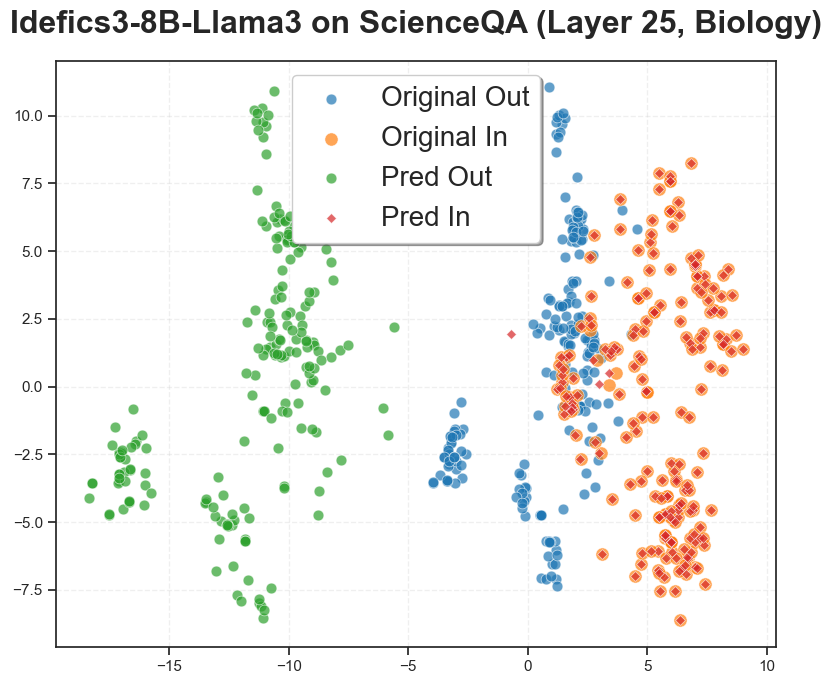

In [159]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
layer = 25
model_name = "Idefics3-8B-Llama3"
dataset_name = "ScienceQA"
subject = "Biology"
load_path = f"/Users/abbottyang/Library/Mobile Documents/com~apple~CloudDocs/PhD_Study/code/autodl/output/results_01/output_Idefics3-8B-Llama3_ScienceQA_biology/activations"

test_out_original = torch.load(f"{load_path}/out_test_activations_{model_name}.pt", weights_only=False, map_location=device)[:, layer, :].double()
test_in_original = torch.load(f"{load_path}/in_test_activations_{model_name}.pt", weights_only=False, map_location=device)[:, layer, :].double()
steering_vec_in = torch.load(f"{load_path}/steering_vec_biology_layer{layer}_{model_name}.pt", map_location=device).double()
steering_vec_out = torch.load(f"{load_path}/steering_vec_nonbiology_refusal_layer{layer}_{model_name}.pt", map_location=device).double()

pred_in = test_in_original + steering_vec_in
pred_out = test_out_original + steering_vec_out

visualize_distributions(test_out_original, test_in_original, pred_out, pred_in, title=f"{model_name} on {dataset_name} (Layer {layer}, {subject})") 


### 2. 显著性检验

/var/folders/bj/tgm5zgnd0zl3z09s4xshwzg40000gn/T/ipykernel_77581/1646058656.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


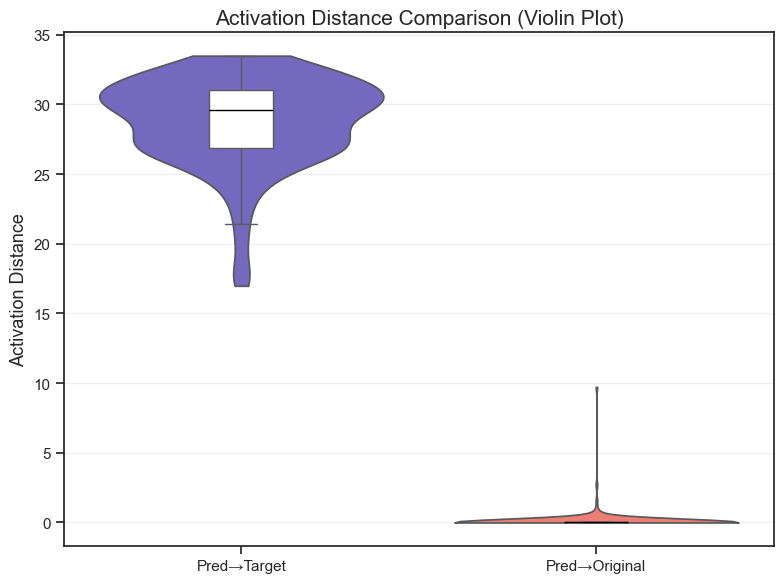

In [169]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
layer = 25
model_name = "Idefics3-8B-Llama3"
dataset_name = "ScienceQA"
subject = "Biology"
load_path = f"/Users/abbottyang/Library/Mobile Documents/com~apple~CloudDocs/PhD_Study/code/autodl/output/results_01/output_Idefics3-8B-Llama3_ScienceQA_biology/activations"

test_in_original = torch.load(f"{load_path}/in_test_activations_{model_name}.pt", weights_only=False, map_location=device)[:, layer, :].double()
test_out_original = torch.load(f"{load_path}/out_test_activations_{model_name}.pt", weights_only=False, map_location=device)[:, layer, :].double()
steering_vec_out = torch.load(f"{load_path}/steering_vec_nonbiology_refusal_layer{layer}_{model_name}.pt", map_location=device).double()
steering_vec_in = torch.load(f"{load_path}/steering_vec_biology_layer{layer}_{model_name}.pt", map_location=device).double()

train_out_original = torch.load(f"{load_path}/without_sys_out_train_activations_{model_name}.pt", weights_only=False, map_location=device)[:, layer, :].double()
train_out_target = torch.load(f"{load_path}/with_sys_out_train_activations_{model_name}.pt", weights_only=False, map_location=device)[:, layer, :].double()

# Predicted activation
pred_out = test_out_original + steering_vec_out
pred_in = test_in_original + steering_vec_in

pred_gap_out = torch.abs(pred_out - train_out_original)
pred_gap_in = torch.abs(pred_in - test_in_original)

significant_test_violin(pred_gap_out, pred_gap_in)

### RQ4: Refusal Score

True


/var/folders/bj/tgm5zgnd0zl3z09s4xshwzg40000gn/T/ipykernel_77581/3743227506.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


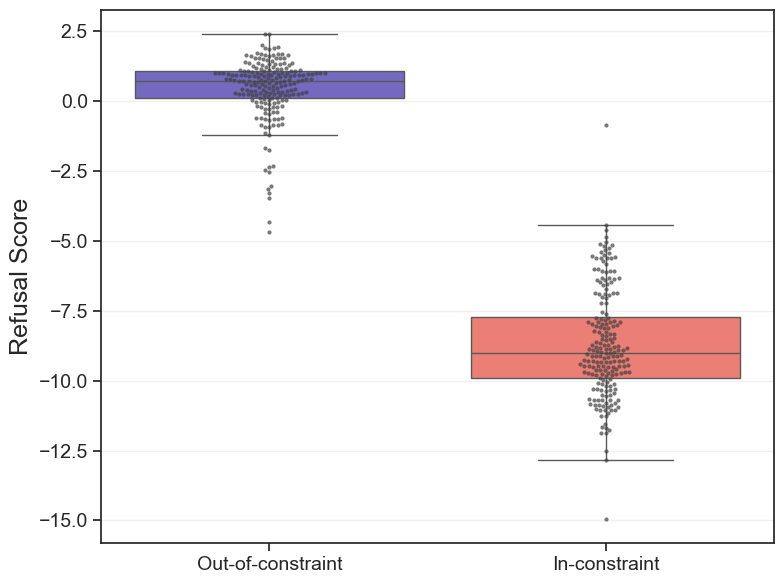

In [ ]:
import pickle
import os
from seaborn import boxplot

model_name = "llava-1.5-7b-hf"
dataset_name = "ScienceQA"
subject = "biology"
save_dir = f"../../../output/results_01_V3/output_{model_name}_{dataset_name}_{subject}/refusal_scores"

print(os.path.exists(save_dir))

# Load out_refusal_scores
with open(f"{save_dir}/out_refusal_scores_{model_name}.pkl", "rb") as f:
    out_refusal_scores = pickle.load(f)

# Load in_refusal_scores
with open(f"{save_dir}/in_refusal_scores_{model_name}.pkl", "rb") as f:
    in_refusal_scores = pickle.load(f)

# Draw boxplot
def draw_Q3(out_refusal_scores, in_refusal_scores):
    # 组装 DataFrame
    df = pd.DataFrame({
        "Refusal Score": out_refusal_scores + in_refusal_scores,
        "Type": (["Out-of-constraint"] * len(out_refusal_scores)) +
                (["In-constraint"] * len(in_refusal_scores))
    })

    # 绘图
    plt.figure(figsize=(8, 6))
    sns.boxplot(
        data=df, x="Type", y="Refusal Score",
        palette=["#6A5ACD", "#FF6F61"],
        showcaps=True, showfliers=False  # 关闭异常值点，可根据需要修改
    )
    sns.swarmplot(  # 若不需要散点可删除这段
        data=df, x="Type", y="Refusal Score",
        color="0.25", alpha=0.7, size=3
    )
    # plt.title("Refusal Score Comparison", fontsize=20)
    plt.xticks(fontsize=14)   # x 轴类目（Out-of-constraint / In-constraint）
    # plt.yticks(fontsize=14)   # y 轴刻度
    plt.xlabel("")
    plt.ylabel("Refusal Score", fontsize=18)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/refusal_score_comparison_{model_name}.png", dpi=160, bbox_inches="tight", facecolor='white')

draw_Q3(out_refusal_scores, in_refusal_scores)